In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
#from gensim.models import Word2Vec
#from gensim.test.utils import datapath
#from gensim import utils
#import gensim
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [ ]:
# To notify when cell is complete (comment out first line). Add %%notify to the first line of a cell to get notified
# !pip uninstall jupyternotify -y
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [4]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=20000)
massive.reset_index(drop=True, inplace=True)

### Pre-processing

In [5]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta
0,Smashed,83.0,Wesley Morris,Boston Globe,Winstead is an inarguably warm actor. She's ju...,NEGATIVE,15.0


In [6]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
dtype: int64

In [7]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Resetting index after dropping dupe's
massive.reset_index(drop=True, inplace=True)
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title             10887
tomatoMeter       19870
criticName        16557
publicatioName    18369
reviewText            0
scoreSentiment    19968
delta             19844
dtype: int64

## BERT Vectorizer

In [8]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
%%notify
# Text preprocessing function
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
massive['embeddings'] = massive.reviewText.map(lambda x: get_embedding(x))
massive.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,embeddings
0,Smashed,83.0,Wesley Morris,Boston Globe,Winstead is an inarguably warm actor. She's ju...,NEGATIVE,15.0,"[-0.65021807, 0.20652938, -0.055883467, -0.048..."


<IPython.core.display.Javascript object>

In [10]:
# Converting embeddings column to numpy array
vectors = np.array(massive.embeddings.tolist(), dtype='float')
vectors[:10]

array([[-6.50218070e-01,  2.06529379e-01, -5.58834672e-02, ...,
        -2.27868438e-01,  1.30321071e-01,  1.86381504e-01],
       [-3.60134214e-01,  8.56944099e-02,  1.45044550e-01, ...,
        -1.73001766e-01,  2.16081500e-01, -7.68406913e-02],
       [-2.21232221e-01,  2.52018154e-01,  2.25870088e-02, ...,
        -1.28468841e-01,  4.96944398e-01,  1.40072465e-01],
       ...,
       [-6.87920034e-01,  2.42279306e-01,  6.83112815e-03, ...,
        -5.07442057e-02,  3.59506518e-01,  3.83950807e-02],
       [-4.69964296e-01,  2.94947684e-01,  2.01409520e-03, ...,
         2.45692878e-04,  3.39448452e-01, -1.27279967e-01],
       [-2.43039429e-02,  4.91188645e-01,  1.64020713e-02, ...,
        -1.76883519e-01,  4.30916607e-01,  1.90584958e-01]])

In [11]:
# Flattening numpy array and creating dataframe with it
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,-0.650218,0.206529,-0.055883,-0.048051,0.402636,0.121062,0.012945,0.373432,-0.096982,-0.168615,...,-0.125275,-0.121889,0.160455,-0.144363,-0.147262,-0.006221,0.377760,-0.227868,0.130321,0.186382
1,-0.360134,0.085694,0.145045,-0.304404,0.331175,0.027101,0.124137,0.568567,-0.088978,-0.357215,...,0.423171,-0.043560,-0.096345,-0.078595,-0.168928,-0.049210,-0.070081,-0.173002,0.216082,-0.076841
2,-0.221232,0.252018,0.022587,-0.028419,0.171354,0.043284,-0.110130,0.482984,-0.193111,-0.206721,...,-0.267829,-0.242352,-0.058089,-0.090936,-0.114885,-0.208406,-0.050643,-0.128469,0.496944,0.140072


In [12]:
# Dropping review text now it is vectorized, and dropping embeddings now that it is flattened
massive = massive.drop(columns=['reviewText', 'embeddings'])

In [13]:
massive.isnull().sum().head(9)

title             0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
dtype: int64

## Encoding Categorical Columns

In [14]:
# Renaming the least-appearing critics as Other to later be encoded as the same critic
counts = massive.criticName.value_counts()
threshold = massive.criticName.isin(counts.index[counts<16])
massive.loc[threshold, 'criticName'] = 'Other'
massive['criticName'].value_counts()

Other                  9951
Dennis Schwartz         138
Jeffrey M. Anderson      99
Roger Moore              98
Roger Ebert              98
                       ... 
Fico Cangiano            16
Alex Sandell             16
Scott Foundas            16
Edward Johnson-Ott       16
Jason Bailey             16
Name: criticName, Length: 335, dtype: int64

In [15]:
# Repeat for publications
counts = massive.publicatioName.value_counts()
threshold = massive.publicatioName.isin(counts.index[counts<12])
massive.loc[threshold, 'publicatioName'] = 'Other'
massive['publicatioName'].value_counts()

Other                       4254
New York Times               271
Variety                      212
Los Angeles Times            189
Time Out                     179
                            ... 
Flavorwire                    12
Schmoes Know                  12
DVDTalk.com                   12
eye WEEKLY                    12
Las Vegas Review-Journal      12
Name: publicatioName, Length: 437, dtype: int64

In [16]:
# List of columns to dummy
categorical_cols = ['title', 'criticName', 'publicatioName', 'scoreSentiment'] 
# Get dummies on categorical columns
massive = pd.get_dummies(massive, columns = categorical_cols)

In [17]:
# Merging massive df with vectorized df
combined = pd.concat([massive, v_df], axis=1)
combined.head(1)

,tomatoMeter,delta,"title_""Sr.""",title_#Female Pleasure,title_#Screamers,title_#Unfit: The Psychology of Donald Trump,title_$9.99,title_'71,title_(500) Days of Summer,title_... And They Lived Happily Ever After,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,83.0,15.0,0,0,0,0,0,0,0,0,...,-0.125275,-0.121889,0.160455,-0.144363,-0.147262,-0.006221,0.37776,-0.227868,0.130321,0.186382


## Splitting, Scaling, PCA

In [18]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [19]:
X.isnull().sum().sum()

0

In [20]:
y[:5]

0    15.0
1     4.0
2    -3.0
3    13.0
4    16.0
Name: delta, dtype: float64

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
%%notify
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

<IPython.core.display.Javascript object>

In [23]:
%%notify
# PCA to filter most important features
pca = PCA(n_components=6000)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

<IPython.core.display.Javascript object>

## Linear Regression

In [23]:
%%notify
# Training learning model
model = LinearRegression()
model.fit(X_train_p, y_train)

LinearRegression()

<IPython.core.display.Javascript object>

In [24]:
model.score(X_train_p, y_train)

0.9167574884879705

In [25]:
model.score(X_test_p, y_test)

0.5149017553473526

In [26]:
y_pred = model.predict(X_test_p)

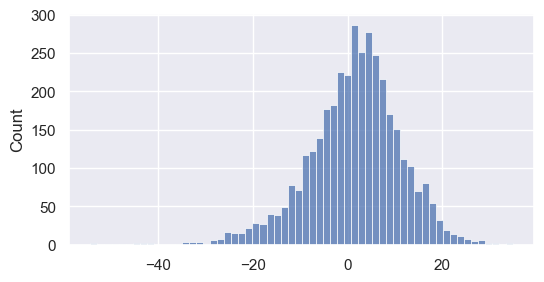

In [27]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_pred)
plt.savefig('BERT_linear_predictions.png')

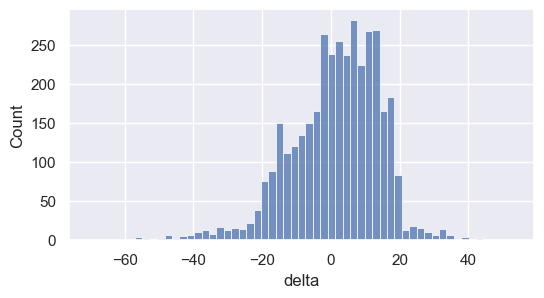

In [28]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_test)
plt.savefig('BERT_linear_ytest.png')

## Random Forest Regressor

In [162]:
%%notify
fmodel = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=30)
fmodel.fit(X_train_p, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=30)

<IPython.core.display.Javascript object>

In [163]:
fmodel.score(X_train_p, y_train)

0.899307196114362

In [164]:
fmodel.score(X_test_p, y_test)

0.21751818610345142

## SVM Regressor (SVR)

In [ ]:
"""%%notify
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear'],
    'epsilon': [0.1, 0.2, 0.5],
    #'gamma': ['scale', 'auto']  # For RBF kernel
}
svr = SVR()

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train_p, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_"""

In [ ]:
best_model.score(X_train_p, y_train)

In [ ]:
best_model.score(X_test_p, y_test)

## ElasticNet Regression

In [24]:
from sklearn.linear_model import ElasticNet
reg = ElasticNet(alpha=10).fit(X_train_p, y_train)
print(reg.coef_)

[-0.         -0.09027859  0.         ...  0.         -0.
 -0.        ]


In [25]:
reg.score(X_train_p, y_train)

0.006466850798346857

In [26]:
reg.score(X_test_p, y_test)

0.007725983375328926